In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools
from scipy.optimize import linear_sum_assignment
import os
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical # used for converting labels to one-hot-encoding
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, Flatten, Conv2D, MaxPool2D,Conv2DTranspose,Reshape
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import itertools
from tensorflow.keras.layers import BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

In [2]:
x_train = np.load('x_train.npy')
x_test = np.load('x_test.npy')
y_train = np.load('y_train.npy')
y_test = np.load('y_test.npy')
y_test = [np.argmax(y)for y in y_test]
y_train = [np.argmax(y)for y in y_train]
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
x=x.reshape((10015,22500))

In [3]:
def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
class ClusteringLayer(keras.layers.Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = keras.layers.InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = keras.layers.InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [5]:
n_clusters = len(np.unique(y))
def DeepCluster(input_shape=(22500), filters=[32, 64, 128, 7]):
    input_img = Input(shape=input_shape)
    x =Dense(5000, activation="relu")(input_img)
    x =Dense(2000, activation="relu")(x)
    x =Dense(1500, activation="relu")(x)
    x =Dense(1000, activation="relu")(x)
    x=Dense(512, activation='relu')(x)
    conv_output = Dense(256, activation='relu')(x)
    label=ClusteringLayer(n_clusters=7,name='clustering')(conv_output)
    classifier = Dense(filters[3], activation='softmax')(conv_output)
    return  [Model(inputs=input_img, outputs=label, name='clustering'),Model(inputs=input_img, outputs=classifier, name='classifier')]

In [6]:
Cluster_net, Classifier_net = DeepCluster()
Cluster_net.summary()
Classifier_net.summary()

Model: "clustering"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 22500)]           0         
_________________________________________________________________
dense (Dense)                (None, 5000)              112505000 
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              10002000  
_________________________________________________________________
dense_2 (Dense)              (None, 1500)              3001500   
_________________________________________________________________
dense_3 (Dense)              (None, 1000)              1501000   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               1

In [7]:
Classifier_net.compile(optimizer=tf.keras.optimizers.SGD(0.01,0.9), loss = "kld")

In [8]:
def target_distribution(q):
    temp =1/(1+q**2)
    temp=temp.transpose()/temp.sum(1)
    temp=temp.transpose()
    return temp

In [9]:
from sklearn.decomposition import PCA
#x_1 = x.reshape((x.shape[0], -1))
#pca = PCA(n_components=10)
#x_2 = pca.fit_transform(x_1)
#kmeans = KMeans(n_clusters=n_clusters)
#y_pred_last = kmeans.fit_predict(x_2)
#Cluster_net.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
#acc(y,y_pred_last)

In [10]:
#print(y_pred_last)

In [11]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
nmi = normalized_mutual_info_score
ari = adjusted_rand_score
print(n_clusters)
y_pred_last=np.zeros(10015)
loss = 0
index = 0
maxiter = 8000
batch_size = 10
update_interval = 100
index_array = np.arange(x.shape[0])
acc_array=np.zeros(67)
loss_array=np.zeros(67)
i=0
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        p = Cluster_net.predict(x)
        y_pred =  p.argmax(1)
        # evaluate the clustering performance
        if y is not None:
            acc_value = np.round(acc(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc=%f, loss=%f' % (ite,acc_value,loss))
            acc_array[i]= acc_value
            loss_array[i]= loss
            i=i+1
        # check stop criterion
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        print(delta_label)
        if (ite>0 and loss<0.0001):
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = Classifier_net.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

Classifier_net.save_weights('./Deep_cluster_model_final.h5')

7
Iter 0: acc=0.488470, loss=0.000000
0.9916125811283075
Iter 100: acc=0.645830, loss=0.001110
0.7988017973040439
Iter 200: acc=0.638140, loss=0.000850
0.08567149276085871
Iter 300: acc=0.643240, loss=0.000630
0.04343484772840739
Iter 400: acc=0.636940, loss=0.000420
0.034847728407388916
Iter 500: acc=0.638340, loss=0.000230
0.03215177234148777
Iter 600: acc=0.636740, loss=0.000390
0.02196704942586121
Iter 700: acc=0.630150, loss=0.000220
0.03055416874687968
Iter 800: acc=0.626360, loss=0.000490
0.026859710434348476
Iter 900: acc=0.643630, loss=0.000480
0.0399400898652022
Iter 1000: acc=0.633650, loss=0.000260
0.028257613579630553
Iter 1100: acc=0.632750, loss=0.000180
0.020968547179231155
Iter 1200: acc=0.637240, loss=0.000180
0.01577633549675487
Iter 1300: acc=0.631650, loss=0.000140
0.013180229655516724
Iter 1400: acc=0.632950, loss=0.000160
0.010783824263604594
Iter 1500: acc=0.636150, loss=0.000190
0.013879181228157763
Iter 1600: acc=0.633250, loss=0.000150
0.011183225162256616
It

In [12]:
# Eval.
q = Classifier_net.predict(x)
# evaluate the clustering performance
y_pred = q.argmax(1)
if y is not None:
    acc_value = np.round(acc(y, y_pred), 5)
    nmi_value = np.round(nmi(y, y_pred), 5)
    ari_value = np.round(ari(y, y_pred), 5)
    loss_value = np.round(loss, 5)
    print('Acc = %.5f, nmi = %.5f, ari = %.5f' % (acc_value, nmi_value, ari_value), ' ; loss=', loss)

Acc = 0.60779, nmi = 0.00545, ari = 0.04119  ; loss= 8e-05


/home/wangligt/environments/tf2_py3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


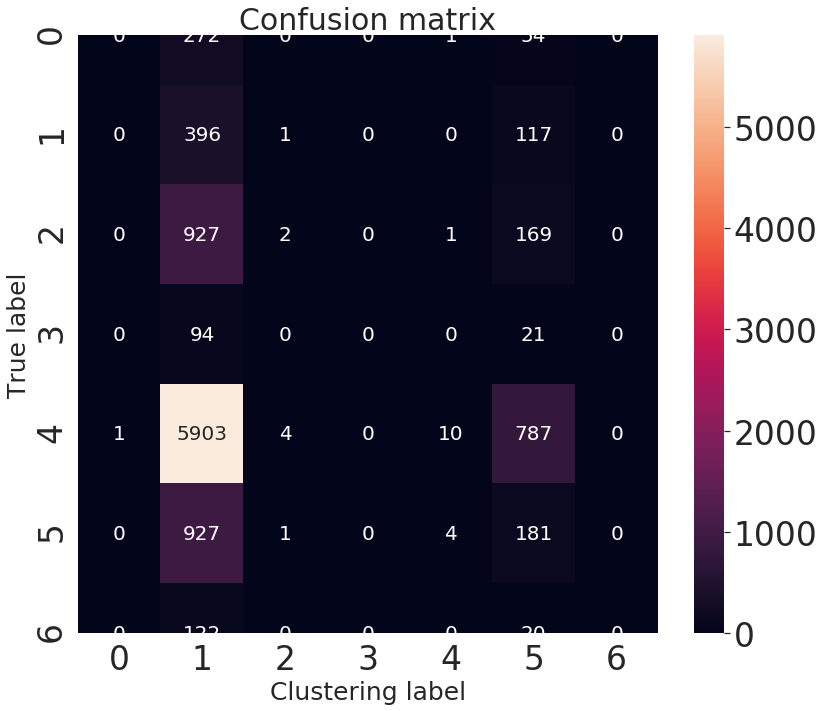

In [13]:
import seaborn as sns
import sklearn.metrics
import matplotlib.pyplot as plt
sns.set(font_scale=3)
confusion_matrix = sklearn.metrics.confusion_matrix(y, y_pred)
plt.figure(figsize=(13, 11))
sns.heatmap(confusion_matrix, annot=True, fmt="d", annot_kws={"size": 20});
plt.title("Confusion matrix", fontsize=30)
plt.ylabel('True label', fontsize=25)
plt.xlabel('Clustering label', fontsize=25)
plt.show()

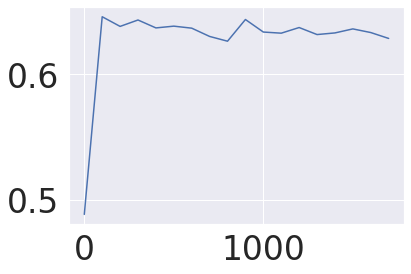

In [23]:
ite=np.linspace(0,1700,18)
plt.plot(ite,acc_array[0:18])
plt.show()

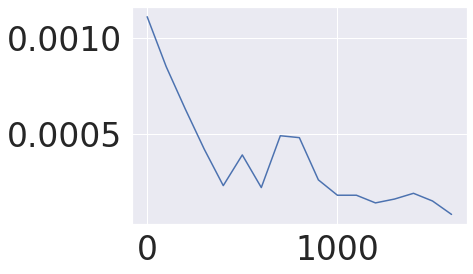

In [24]:
ite=np.linspace(0,1600,17)
plt.plot(ite,loss_array[1:18])
plt.show()

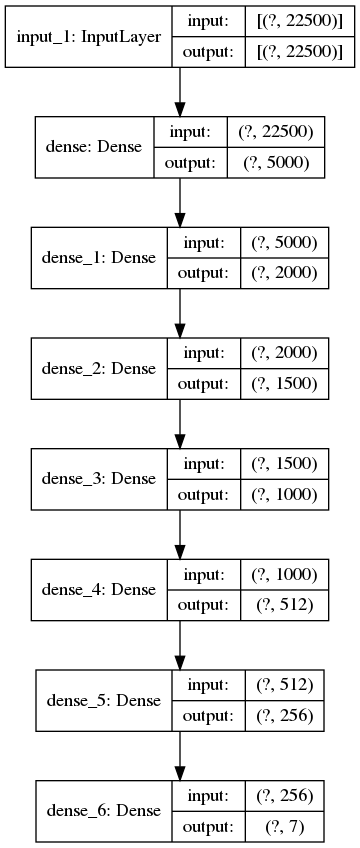

In [19]:
from tensorflow.keras.utils import plot_model
plot_model(Classifier_net, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 

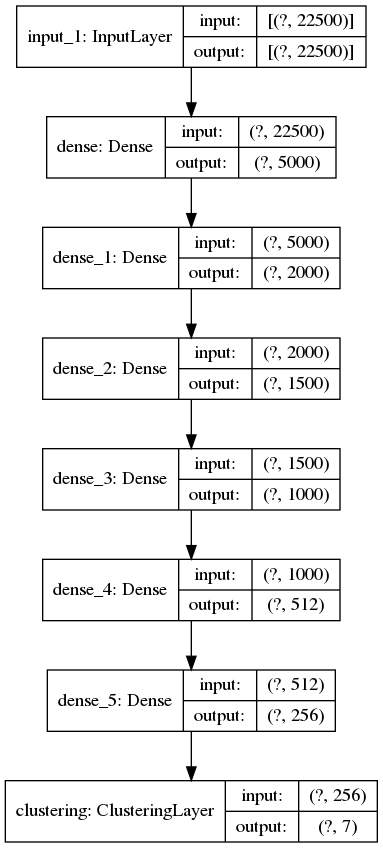

In [20]:
from tensorflow.keras.utils import plot_model
plot_model(Cluster_net, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png') 